# **Bottle-gourd Disease Detection using custom CNN models** 

In [9]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-q062wzeb
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-q062wzeb
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import zipfile
import os
from tqdm import tqdm  # Import tqdm for progress bars

## Pre-Processing and Load the Dataset

In [11]:
# Define transformations with potential augmentations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/bottle-gourd/Bottle gourd", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Data Visualization for each class

['Anthracnose', 'Downey mildew', 'Fresh leaf']
{'Anthracnose': 0, 'Downey mildew': 1, 'Fresh leaf': 2}
3


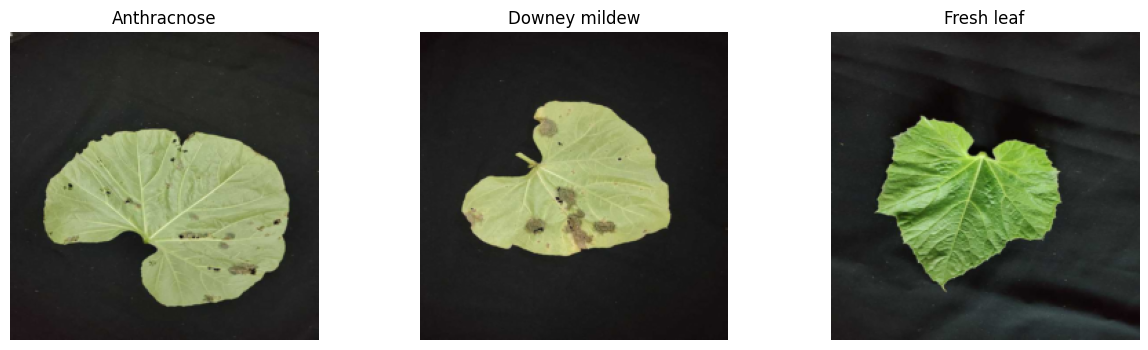

In [12]:
class_names = dataset.classes
print(class_names)
print(dataset.class_to_idx)
# Output: {'anthracnose': 0, 'downey mildew': 1, 'fresh leaf': 2}
num_classes = len(class_names)
print(num_classes)
fig, axs = plt.subplots(1, num_classes, figsize=(15, 4))
# Dictionary to track displayed images per class
displayed_classes = {class_name: False for class_name in class_names}

# Loop through the data to get at least one sample from each class
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        # Display the image if not already displayed for this class
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Unnormalize the image
            axs[label].imshow(np.clip(img, 0, 1))  # Clip to valid range
            axs[label].set_title(class_name)
            axs[label].axis('off')
            displayed_classes[class_name] = True  # Mark as displayed

        # Break if all classes are displayed
        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break
plt.show()

## Define a Custom CNN model

In [13]:
class CustomCNN(nn.Module):

    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, len(class_names))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 256 * 16 * 16)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


## Transfer Learning Model

In [14]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch.nn as nn
import timm

def get_transfer_model(model_name, num_classes):
    if model_name == "resnext101_32x8d":
        model = timm.create_model("resnext101_32x8d", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "densenet201":
        model = timm.create_model("densenet201", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "efficientnetv2_s":
        model = timm.create_model("efficientnetv2_s", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "nasnetalarge":
        model = timm.create_model("nasnetalarge", pretrained=True)
        model.last_linear = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "convnext_base":
        model = timm.create_model("convnext_base", pretrained=True)
        model.head = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "xception":
        model = timm.create_model("xception", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' not supported. Please check the name.")

    return model
